In [1]:
# BERT利用モデリングの作法

# TODO：
# 検証用データ追加
# チューニング
# triplet_loss(別タスク)

In [2]:
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0
!pip install datasets

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 486 kB 47.9 MB/s 
     |████████████████████████████████| 13.4 MB 40.4 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
     |████████████████████████████████| 3.3 MB 29.4 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=6a1ebf8fcfb692a6750e68ca5fe2dd2e974375b7a776fc90e0fedd747f8f2aac
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic
     |████████████████████████████████| 311 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 59.2 MB/s 
     |████████████████████████████████| 243 kB 55.4 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 54.8 MB/s 
     |████████████████████████████████| 144 kB 48.9 MB/s 
     |████████████████████████████████| 271 kB 57.5 MB/s 
     |███████████████

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from transformers import BertJapaneseTokenizer, BertModel, BertConfig

MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [4]:
import re
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive/")
PATH = "/content/drive/My Drive/NLP/work/02_pytorch_modeling/"  

Mounted at /content/drive/


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [6]:
# トークナイザーのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME) 

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

In [7]:
# 入力
from datasets import load_dataset
INPUT_PATH = "/content/drive/My Drive/NLP/work/02_pytorch_modeling/input/"  

#train_data = []
#test_data = []

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=128)

train_data = load_dataset("csv", data_files=INPUT_PATH+"news_train.csv", column_names=["text", "label"], split="train")
train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
train_data.set_format("torch", columns=["input_ids", "label", "attention_mask"])
#train_data.set_format("torch", columns=["input_ids", "label"])

test_data = load_dataset("csv", data_files=INPUT_PATH+"news_test.csv", column_names=["text", "label"], split="train")
test_data = test_data.map(tokenize, batched=True, batch_size=len(test_data))
test_data.set_format("torch", columns=["input_ids", "label", "attention_mask"])
#test_data.set_format("torch", columns=["input_ids", "label"])

print(train_data.shape, test_data.shape) # text, label, input_ids, token_type_ids, attention_mask

Using custom data configuration default-e6b0e146bedc4e99


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e6b0e146bedc4e99/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

Using custom data configuration default-65469faf6ffce287


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-65469faf6ffce287/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

(209, 5) (70, 5)


In [8]:
# データ分割(バッチ)
from torch.utils.data import DataLoader
BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# モデルのロード
bert = BertModel.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [10]:
# モデル定義
class DocCls(nn.Module):
  def __init__(self, bert):
    super(DocCls, self).__init__()
    self.bert = bert
    self.cls = nn.Linear(768,9)
  def forward(self, x1, x2):
    output = self.bert(input_ids=x1, attention_mask=x2)
    batch_size = len(output[0])
    h0 = [output[0][i][0] for i in range(batch_size)]
    h0 = torch.stack(h0, dim=0)
    h1 = self.cls(h0)
    return h1

In [11]:
# モデル生成(全層の学習)
EPOCH_SIZE = 15
LEARNING_RATE = 0.001

model = DocCls(bert).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#print(model)

In [12]:
# # モデル生成(CLS層のみの学習)
# EPOCH_SIZE = 6
# LEARNING_RATE = 0.001

# model = DocCls(bert).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.cls.parameters(), lr=LEARNING_RATE)

# for name, param in model.named_parameters():
#   if name=="cls.weight" or name=="cls.bias":
#     param.requires_grad = False
#     #print(name)

In [13]:
# # モデル生成(CLS層＋12,11層のみの学習)
# EPOCH_SIZE = 6
# LEARNING_RATE = 0.001

# model = DocCls(bert).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD([{"params":model.bert.encoder.layer[11].parameters(), "lr":LEARNING_RATE},
#                        {"params":model.bert.encoder.layer[10].parameters(), "lr":LEARNING_RATE},
#                       {"params":model.cls.parameters(), "lr":LEARNING_RATE}]) 

# for name, param in model.named_parameters():
#   if name=="cls.weight" or name=="cls.bias":
#       param.requires_grad = False
#   if re.search("bert.encoder.layer.11", name):
#      param.requires_grad = False
#   if re.search("bert.encoder.layer.10", name):
#      param.requires_grad = False

In [ ]:
# 学習
model.train()

acc_hist = []
loss_hist = []

for epoch_num in range(EPOCH_SIZE):
  collect_sum = 0
  loss_sum = 0.0

  for i, batch in enumerate(train_loader):
    x1 = batch['input_ids'].to(device)
    x2 = batch['attention_mask'].to(device)
    y = batch['label'].to(device)
    #x = torch.LongTensor(train_data['input_ids'][i]).unsqueeze(0).to(device)
    #y = torch.LongTensor(train_data['label'][i]).unsqueeze(0).to(device)
    output = model(x1, x2)
    # print(output)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    # print(loss_sum)

    ans = torch.argmax(output, dim=1)
    collect_sum += sum(ans==y).item()
    #print(ans==y)

  # 評価
  acc_hist.append(collect_sum/len(train_data))
  loss_hist.append(loss_sum)

  # モデルの保存(Epoch毎)
  #torch.save(model.state_dict(), PATH + "tmp_model/doccls-" + str(epoch_num) + ".model")

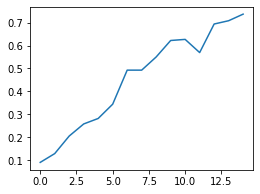

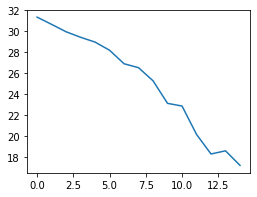

In [ ]:
# 可視化
plt.figure(figsize=(4,3))
plt.plot(acc_hist)
plt.show()

plt.figure(figsize=(4,3))
plt.plot(loss_hist)
plt.show()

In [ ]:
# 推論
model.eval()

with torch.no_grad():
    #x = torch.LongTensor(test_data['input_ids']).to(device) # unsqueezeなし(batch)
    x1 = test_data['input_ids'].to(device)
    x2 = test_data['attention_mask'].to(device)
    output = model(x1, x2)
    #print(output.shape)
    ans = torch.argmax(output, dim=1)
    #print(ans.shape)
    #print(ans)
    #print(test_data['label'])
    correct = sum(ans == test_data['label'].to(device))
    print(f"精度：{correct/len(test_data)}")

精度：0.5285714268684387
